In [ ]:
import cv2 as cv
import matplotlib.pyplot as plt
import os 
from os import listdir
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
import itertools

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


The goal will be to obtain binary images( pixels in the image take two values) -> Binarization

I will implement this using the thresholding method, a certain threshold value of the brightness of a pixel is set, which will decide whether the pixel will take the value of 0 or 1.

The main purpose of obtaining a binary image is to separate the searched object from the background.

To begin with, loading the data
I want to load one image and save it in a list holding all images
A method that takes the path to a folder with images, and sequentially loads as many of them as there are files in the folder

In [ ]:
SOURCE_PATH = "drive/MyDrive/leaf_dataset/leaves_testing_set_1/color_images"

def load_images(folder_dir):
  leaf_storage = []
  for element in os.listdir(folder_dir):
    if element.endswith(".png"):
      gray_leaf = cv.imread(folder_dir+"/"+element, cv.IMREAD_GRAYSCALE)
      leaf_storage.append(gray_leaf)
  return leaf_storage


In [ ]:
leaf_images = load_images(SOURCE_PATH)

In [ ]:
len(leaf_images)

150

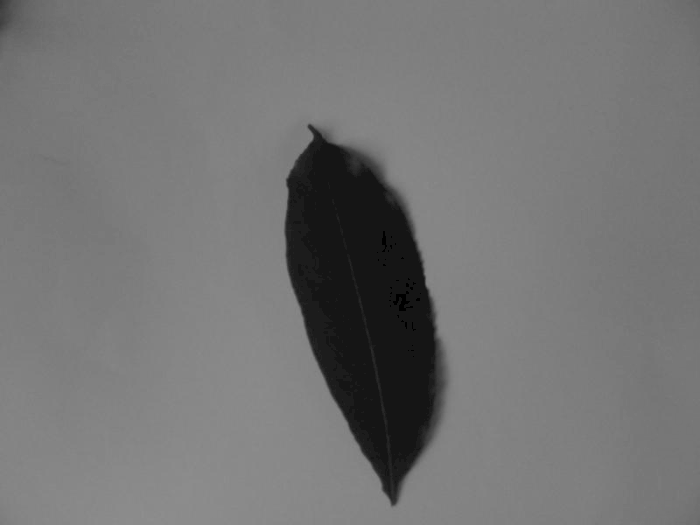

In [ ]:
cv2_imshow(leaf_images[2])

A method that reads the number of repeated pixel values of an image, returning a dictionary to be used to create the histogram

In [ ]:
def num_of_pixel_val(img):
  pixel_dict = {}
  rows,cols = img.shape
  for row in range(rows):
    for col in range(cols):
      value = img[row,col]
      if value in pixel_dict:
        pixel_dict[value] += 1
      else:
        pixel_dict[value] = 1
  for num in range(256):
    if num not in pixel_dict:
      pixel_dict[num] = 0
  return pixel_dict

The essential step is to generate a histogram of the image, which will show the distribution of pixel brightness in the image. Based on the analysis of the histogram, a threshold value is selected, there are various methods for finding such a value.

A method that creates a histogram based on a dictionary

In [ ]:
def plot_hist(pixel_dict):
  my_keys = list(pixel_dict.keys())
  my_keys.sort()
  sorted_dict = {i:pixel_dict[i] for i in my_keys}
  pixel_value = list(sorted_dict.keys())
  reps = list(sorted_dict.values())

  f, ax = plt.subplots(figsize=(110, 10))
  plt.bar(range(len(sorted_dict)), reps, tick_label=pixel_value)
  plt.show()

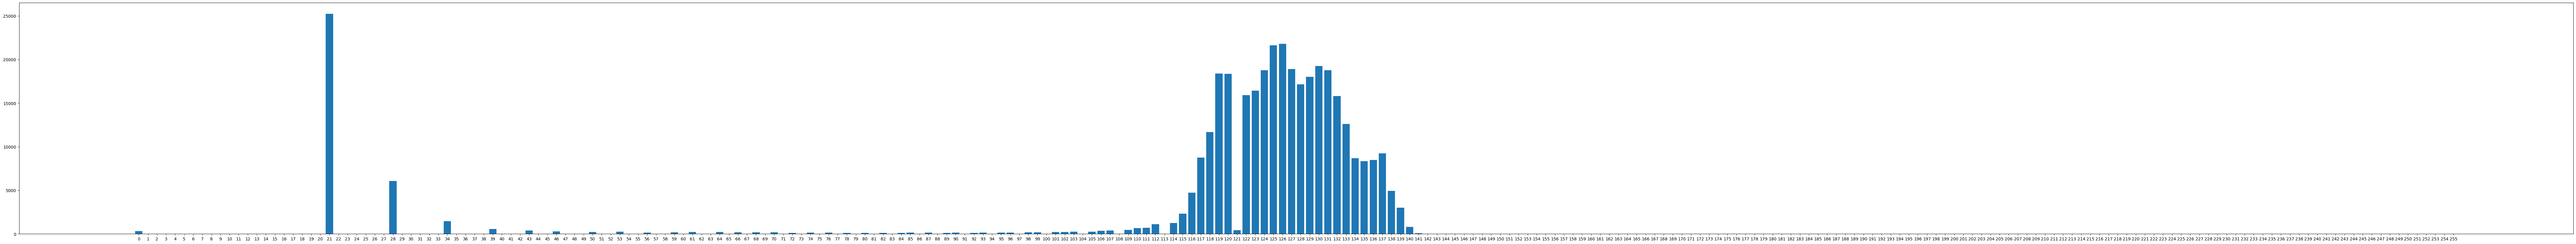

In [ ]:
pixel_dict = num_of_pixel_val(leaf_images[2])
plot_hist(pixel_dict)


I'll check how the Otsu method performs



c = [c0,c1,...,c255] -> c number of occurrences of a given pixel
column centers v = [v1, v2,...,v3].
I have a dictionary containing the values of pixels 0-255 and the number of repetitions of a given pixel

            HEAD method :accepts the dictionary
              list of variants
                for i in range(0,255)
                  dictionary[:i] left
                  variance left
                  dictionary[i:] right side
                  right variance
                  writing the sum of the weighted variance and the pixel value
                  checking if the new sum is smaller


both sides calculate the variance and save to the list
check which item in the list has the lowest value -> its idenx is the threshold

In [ ]:
def variance(pixel_dict):
  weight = get_weight(pixel_dict)
  mean = sum(pixel_dict.values())/len(pixel_dict) * weight
  val_sqr_sum = 0

  for key in pixel_dict:
    val_sqr_sum += (pixel_dict[key] - mean)**2
  variance = val_sqr_sum/len(pixel_dict) * weight

  return variance

In [ ]:
def get_weight(pixel_dict):
  return len(pixel_dict)/256

In [ ]:
def find_treshold(pixel_dict):
  v_min = -1
  tresh = -1
  for i in range(1, 256):
    q1,q2 = pixel_dict[i],pixel_dict[255]-pixel_dict[i]
    left_dict = dict(itertools.islice(pixel_dict.items(), 0, i))
    v_left = variance(left_dict)
    weight_left = get_weight(left_dict)

    right_dict = dict(itertools.islice(pixel_dict.items(), i, None))
    v_right = variance(right_dict)
    weight_right = get_weight(right_dict)

    v_sum = v_right * weight_right  + v_left * weight_left
    if i == 1:
      v_min = v_sum
      tresh = i
    if v_sum < v_min:
      v_min = v_sum
      tresh = i

  return tresh

In [ ]:
def regenerate_img(img, threshold):
    row, col = img.shape 
    y = np.zeros((row, col))
    for i in range(0,row):
        for j in range(0,col):
            if img[i,j] >= threshold:
                y[i,j] = 255
            else:
                y[i,j] = 0
    return y

66


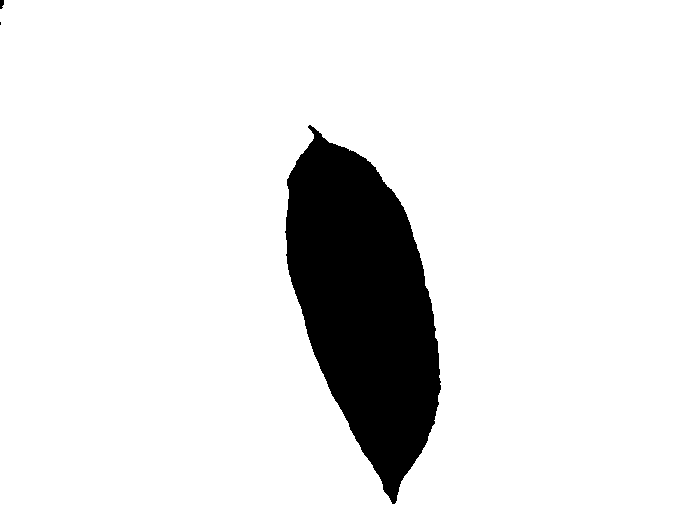

In [ ]:
treshold = find_treshold(pixel_dict)
print(treshold)
final_img = regenerate_img(leaf_images[2], treshold)

cv2_imshow(final_img)